In [268]:
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import math

#Define universal gravitation constant
G=6.67408e-11 #N-m2/kg2
#Reference quantities
m_nd=1.989e+30 #kg #mass of the sun
r_nd=5.326e+12 #m #distance between stars in Alpha Centauri
v_nd=30000 #m/s #relative velocity of earth around the sun
t_nd=79.91*365*24*3600*0.51 #s #orbital period of Alpha Centauri
#Net constants
K1=G*t_nd*m_nd/(r_nd**2*v_nd)
K2=v_nd*t_nd/r_nd

#Simulation params
runtime=10
dt = 0.001
total_steps = int(runtime/dt) #(10,000)
sampling_rate = 100
frames = range(0,total_steps,sampling_rate)

In [269]:

class Universe:
    def __init__(self, num_bodies=4, g=9.8, air_friction_coeff=0.5):
        self.g = g
        self.air_friction_coeff = air_friction_coeff
        self.num_bodies = num_bodies
        self.world = []
        self.body_count = 0
        self.time = 0
        
    def addBody(self, body):
        if self.body_count<=self.num_bodies:
            self.world.append(body)
        else:
            print('Universe full, cannot add more bodies!')
        return self.world
    
    def step(self, dt):
        for index,body in enumerate(self.world):
            #update positions
            body.xarr.append(body.updateX(dt))
            body.yarr.append(body.updateY(dt))
            body.zarr.append(body.updateZ(dt))
            
            #update velocities and in turn acc
            body.updateVx(dt,self.world,index)
            body.updateVy(dt,self.world,index)
            body.updateVz(dt,self.world,index)
            
        #step in time
        self.time = self.time + dt

    

In [270]:
class Body:
    def __init__(self, mass, x0, y0, z0, vx0, vy0, vz0):
        """
        Body definition
        """
        #Mass in Kg
        self.mass = mass 
        
        # current x and y coordinates of the missile
        self.x = x0
        self.y = y0
        self.z = z0 
        
        # current value of velocity components
        self.vx  = K2*vx0
        self.vy  = K2*vy0
        self.vz  = K2*vz0
        
        # acceleration by x and y axes
        self.ax   = 0
        self.ay   = 0
        self.az   = 0
        
        # these list will contain discrete set of missile coordinates
        self.xarr = [self.x]
        self.yarr = [self.y]
        self.zarr = [self.z]
        
    def updateX(self, dt):
        self.x = self.x + self.vx*dt + self.ax*dt*dt
        return self.x
    
    def updateY(self, dt):
        self.y = self.y +  self.vy*dt + self.ay*dt*dt
        return self.y
    
    def updateZ(self, dt):
        self.z = self.z +  self.vz*dt + self.az*dt*dt
        return self.z
    
    def updateAx(self, bodies, body_index):
        self.ax=0
        for index, external_body in enumerate(bodies):
            if index != body_index:
                r = (self.x - external_body.x)**2 + (self.y - external_body.y)**2 + (self.z - external_body.z)**2
                r = math.sqrt(r)
                tmp = external_body.mass / r**3
                self.ax += tmp * (external_body.x - self.x)
                
        return K1*self.ax
    
    def updateAy(self, bodies, body_index):
        self.ay=0
        for index, external_body in enumerate(bodies):
            if index != body_index:
                r = (self.x - external_body.x)**2 + (self.y - external_body.y)**2 + (self.z - external_body.z)**2
                r = math.sqrt(r) #norm
                tmp = external_body.mass / r**3
                self.ay += tmp * (external_body.y - self.y)
        return K1*self.ay
    
    def updateAz(self, bodies, body_index):
        self.az=0
        for index, external_body in enumerate(bodies):
            if index != body_index:
                r = (self.x - external_body.x)**2 + (self.y - external_body.y)**2 + (self.z - external_body.z)**2
                r = math.sqrt(r)
                tmp = external_body.mass / r**3
                self.az += tmp * (external_body.z - self.z)
        return K1*self.az
        
    def updateVx(self, dt , bodies, body_index):
        self.vx = self.vx + 0.5*(self.ax + self.updateAx(bodies, body_index))*dt
        return K2*self.vx
    
    def updateVy(self, dt , bodies, body_index):
        self.vy = self.vy + 0.5*(self.ay + self.updateAy(bodies, body_index))*dt
        return K2*self.vy
    
    def updateVz(self, dt , bodies, body_index):
        self.vz = self.vz + 0.5*(self.az + self.updateAz(bodies, body_index))*dt
        return K2*self.vz

In [274]:
def plot_trajectories3D(trajectories,frames=frames):
    """Trajectories is a list of list containing a triplet of lists 
       for x, y and z co-ordinates for each object for each instance in time.
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    lines=[]
    empty_xs = []
    empty_ys = []
    empty_zs = []
    for i,_ in enumerate(trajectories):
        des = ['r-','b-','g-','y-']
        line, = ax.plot([], [], [], des[i])
        lines.append(line)
        empty_xs.append([])
        empty_ys.append([])
        empty_zs.append([])

    # initialization function: plot the background of each frame
    def init():
        for line in lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return lines

    # animation function. This is called sequentially
    def animate(i):
        for j,traj in enumerate(trajectories):
            if i<len(traj[0]):
                try:
                    empty_xs[j].append(traj[0][i])
                    empty_ys[j].append(traj[1][i]) 
                    empty_zs[j].append(traj[2][i])
                    lines[j].set_data(empty_xs[j],empty_zs[j])
                    lines[j].set_3d_properties(empty_ys[j])
                except:
                    pass

        try:
            ax.set_xlim((-1+np.min(empty_xs), 1+np.max(empty_xs)))
            ax.set_ylim((-1+np.min(empty_zs), 1+np.max(empty_zs)))
            ax.set_zlim((-1+np.min(empty_ys), 1+np.max(empty_ys)))
        except:
            pass 

        return (lines)
        

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=100, blit=True)

    return anim

In [278]:

def run_simulation(bodies):
    """
    Returns a tuple with sequential pairs of x and y coordinates
    """
    universe = Universe()
    for body in bodies:
        universe.addBody(body)
    
    t = 0 # initial time
    universe.step(dt)

    ###### Step through ######
    while universe.time <= runtime:
        universe.step(dt)
        t = t + dt
    ##############################
    trajectories = []
    for body in universe.world:
        trajectories.append([body.xarr, body.yarr,body.zarr])

    return trajectories




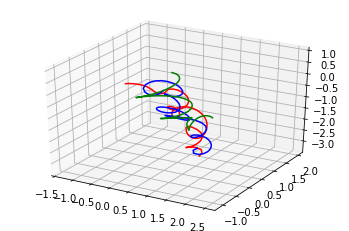

In [279]:
#Test data
bodies=[]
bodies.append(Body(1.1, -.5, 0, 0, 0.01, 0, 0.01))
bodies.append(Body(0.907, .5, 0, 0, -0.05, -0.1, 0))
bodies.append(Body(1., 0, 0, 1, 0.09, 0, -0.01))

traj = run_simulation(bodies)

#Test Vis
anim = plot_trajectories3D(traj)
HTML(anim.to_html5_video())